# Prototype Auto-encoder

### Code
**Repo**: https://github.com/DGeisz/prototype_ae

### Intro

* **Date**: 11/19/2020


* **Why**: This particular architecture is compelling because it's trained with gradient descent, rather than some competitive algorithm.  For an RQI, not only is it important to understand the latent space, but it's equally important to understand the maps between the input and latent spaces.  In traditional auto-encoders, these mappings are learned, and they're effectively black boxes.  Without understanding the structure of these mappings, you can't really understand the structure of the latent space.  In this algorithm, both mappings are quite straightforward and understandable.  Even though parameters in the mapping are learned, the purpose of the mappings are always clear.  Another issue with the structure of traditional auto-encoders is that when they interact with new data, the mappings are altered to better reconstruct data.  This means that the latent space doesn't have a stable structure, which effectively implies that if you have a series of hierarchical RQIs, (which is obviously the case in the brain), the meaning of the inputs is very fluid, and higher levels can't as easily learn deterministic representations of lower levels.  With the prototype auto-encoder, the nature of the mapping allows the meaning of each latent variable become more "fixed" over time, so higher levels can gain a good deterministic understanding of lower level inputs.


* **What**: This is a one-layer network of neurons that is fully-connected to an input.  Each synapse between a neuron and an input has a learned weight.  These weights form a prototype, and the loss function for this network is essentially defined to be the extent to which the different neuron prototypes can come together (in a weighted fashion) to reconstruct the input.  To get technical, for a given input vector, each neuron calculates a weighted average of each of the components, weighted by their synaptic weight.  This weighted average is multiplied by the weight prototype, and the weighted prototypes from all neurons are summed.  The loss function is the sum of the square difference between the input and the resultant prototype.  The network is trained using gradient descent.  Due to the weighted averages and the sum of weighted prototypes, the derivatives are a bit more involved than a standard DNN.  Even though there isn't really an activation function at any step, this network is non-linear (and in fact, quadratic) due to the multiplication of the weighted average with each pixel value.


* **Hopes**: I hope that this network is able to learn a diverse set of prototypes for the data.  I also hope that the gradient-based learning algorithm allows the network to move towards an optimal state as quickly as possible.  Competitive prototype-learning algorithms are based on some logical process that isn't necessarily optimal, so ideally, this network is able to learn a more robust and diverse set of prototypes than other competitive learning algorithms.


* **Limitations**: Previous experiments have shown me that if all prototypes are learned using the same type of adjustment at each step, the prototypes all tend toward the same state.  While this happened for simpler learning algorithms, it seems like the same sort of behavior could occur here.  If this occurs, I'll need to figure out a way to treat each prototype separately at each learning step.  The other limitation is that data is received at each neuron in an all-to-all fashion, only one flow of information is passing through the neuron, rather than burst of information passing through the neuron at different times, as is the case in spiking networks.  In other words, there's no notion of an input being "off," and therefore not affecting the output.  One way to possibly address this is to weight each weight by the synaptic input, so inputs that have a measure of 0 aren't even factored into the calculation of the weighted average.  That might be cool because it would introduce even more non-linearities.  This is all I'll say before the experiment starts.

## Analysis Dialog

After running this bad boi, the first thing that I feel I should report is that it's *so so* slow.  Training 100 neurons on 10,000 images took about 1.75 hours.  That's egregious.  Now, after I ran this, I realized I had some super redundant code, but that's still crazy long.  The simple reason for this is that the learning step is quite involved due to the entangled gradients.  With that said, one incredibly important thing to do moving forward from this experiment is to figure out how to make the learning step faster.  One simplification I can do is assume the weighted average is constant when taking the gradient.  That's obviously a big simplification, but it would drastically speed up the learning step.

Anyway, let's talk data.  Because this bad boi is a slow boi, I haven't run many trials.  However, with 10 neurons trained on 10,000 images had an accuracy of 41% using this [mnist metric](https://github.com/DGeisz/CodeX/tree/main/Reductionist%20Quasi-Isomorphisms/11_18_2020_metric_mnist_competitive_classification).  That's not bad relative to some of the other competitive algorithms I've been cooking up.  This network with 100 neurons trained on the same number of images got 61% accuracy using the same metric.  That's actually pretty neat.  That's doing better than the winner-takes-all algo I cooked up, and it's doing about as well as the self-organizing map algo trained on 60,000 images.  So yeah that's great.  

However, I was super wrong about how the network was going to work.  Soooo remember how I call this a prototype auto-encoder?  Well, ...ahem... it SUPER doesn't learn prototypes.  I believe this architecture is what the kids (established AI researchers) call a sparse encoder.  I'll load in some data so you can see what I mean.  

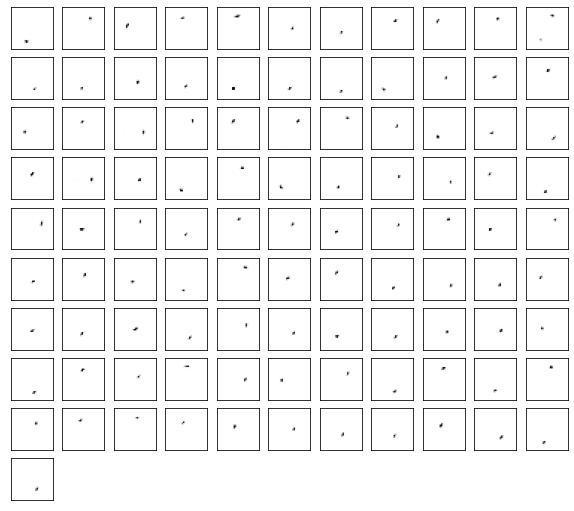

In [10]:
num_imgs = len(good_data)

side_len = int(((num_imgs ** 0.5) // 1.0) + 1)

plt.figure(figsize=(10, 10))
for i, img in enumerate(good_data):
    plt.subplot(side_len, side_len, i + 1)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # plt.imshow(img[0], cmap="RdBu", alpha=img[1], vmin=0, vmax=1)
    # plt.imshow(img, cmap="Greys", vmin=0, vmax=1)
    plt.imshow(img, cmap="Greys")

plt.show()

Ok, so what are we looking at?  I'm plotting the learned weights in the same position as each pixel in the mnist image.  So each image corresponds to one neuron.  And what do they look like?  Well, dots. Those are super not image prototypes.  However, this is actually really cool, because this means that the neuron output are entirely uncoupled, which means that there aren't redundancies in the neuron outputs.  Cool!  Now, why is this happening?  Well, I don't have a perfect explanation, but there are a couple things going on here.  One non-trivial aspect of the current dataset is that it's mostly whitespace, which has a measure of 0.  That means on average, there should be a downward pressure on the weights.  Now why does anything show up?  Well, unlike some of my previous algorithms, instead of taking an average of the output predictions of each neuron, the outputs are simply summed up.  I have an idea of why this is happening, but it's difficult to put into words.  Basically it seems like this architecture rewards when its synapses with non-zero weights are as correlated as possible, which would naturally occur for local pixels.  Hence after learning, the only non-zero weights are intensely local. 

Anyway, it seems like the reason I'm getting these sparse encodings it simply because the final output of the ae is a sum rather than an average.  When the output is an average of each neuron's predictions, then each neuron is compelled to form a more complete picture of the output, like a full prototype.  This is why my other competitive algorithms ended up with weights that looked like shadow numbers.  [This snn](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full) also learned weight-prototypes when trained on mnist.  I think this is because the neurons are only competing with each other.  When the neurons are allowed to collaborate to form the final reproduction, then they're able to specialize a bit more, like they're clearly doing right now.

Now one thing that's evident from the above image it that each neuron is only learning one particular artifact.  That's to be expected because the current setup prioritizes deterministic behavior about all else.  I think if I calculated outputs in a slightly different manner, I might be able to get each neuron to respond to several uncorrelated artifacts in the data.  I think I could potentially do this by weighting the weights with the current input measure.  Actually, I should really talk about how I'm calculating the prediction right now.  

Ok, so let $w_{ij}$ be the weight of the $j^{th}$ synapse of the $i^{th}$ neuron.  Let $q_i$ be the measure of $i^{th}$ input pixel, and $p_i$ be the prediction of the $i^{th}$ pixel.  Also $m$ is the number of input pixels in the input (784), and $n$ is the number of neurons. Then the following is how the prediction is calculated:

$$
p_i = \sum_{i = 0}^{n} \left(\frac{\sum_{j = 0}^{m} q_i w_{ij}}{\sum_{j = 0}^{m} w_{ij}}\right) w_{it}
$$

Even though this has been incredibly good for me to see, I'm still not a huge fan of the current architecture because of how incredibly slow it is.  So I'm going to have some quick fun here plotting the reconstructed images, and seeing what they look like.  

First here's a plot of the weight-images when I force the values to be between 0 and 1

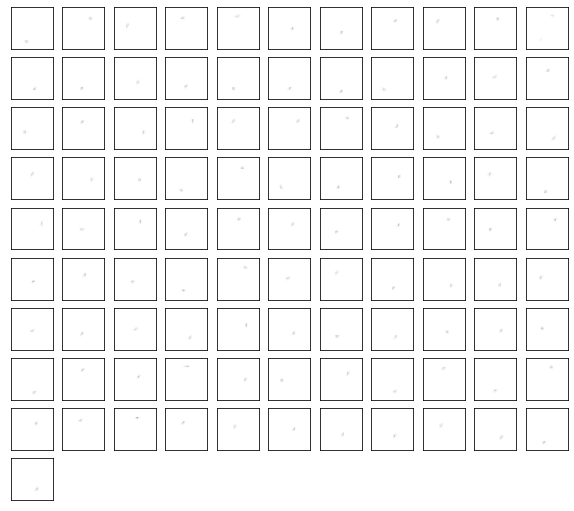

In [12]:
num_imgs = len(good_data)

side_len = int(((num_imgs ** 0.5) // 1.0) + 1)

plt.figure(figsize=(10, 10))
for i, img in enumerate(good_data):
    plt.subplot(side_len, side_len, i + 1)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # plt.imshow(img[0], cmap="RdBu", alpha=img[1], vmin=0, vmax=1)
    plt.imshow(img, cmap="Greys", vmin=0, vmax=1)

plt.show()

Notice how light they are.  Because these weights are so light, you can clearly see that there is still significant loss in the reconstruction.  Oh, I should mention that I'm using simple sum of squares loss to calculate the gradient.  Ok, let's try to reconstruct some images.

In [15]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, _), _ = mnist.load_data()

Ok so here's the first image I'm going to try to reconstruct.

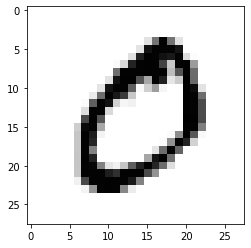

In [20]:
plt.imshow(x_train[1], cmap="Greys")

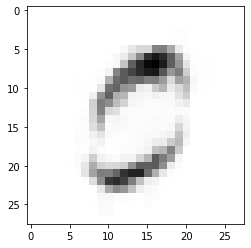

In [24]:
img = x_train[1]
new_img = [[0 for _ in range(28)] for _ in range(28)]

for img_i in range(28):
    for img_j in range(28):
        for t in range(100):
            weighted_measure = 0
            total_weights = 0
            for i in range(28):
                for j in range(28):
                    weighted_measure += good_data[t][j][i] * img[j][i]
                    total_weights += good_data[t][j][i]
            new_img[img_j][img_i] += (weighted_measure / total_weights) * good_data[t][img_j][img_i]
            
plt.imshow(new_img, cmap="Greys")

Ok so that's not too bad.  Obviously it has the general shape pretty well down.  I'll do some reconstructions for a couple of other images then we'll move on to conclusions.

In [25]:
def show_img_and_reconstruction(img_i):
    img = x_train[img_i]
    new_img = [[0 for _ in range(28)] for _ in range(28)]

    for img_i in range(28):
        for img_j in range(28):
            for t in range(100):
                weighted_measure = 0
                total_weights = 0
                for i in range(28):
                    for j in range(28):
                        weighted_measure += good_data[t][j][i] * img[j][i]
                        total_weights += good_data[t][j][i]
                new_img[img_j][img_i] += (weighted_measure / total_weights) * good_data[t][img_j][img_i]
    print("OG")
    plt.imshow(img, cmap="Greys")
    print("Reconstruction")
    plt.imshow(new_img, cmap="Greys")

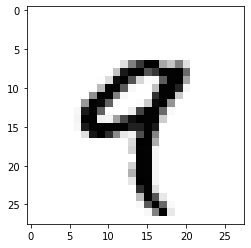

In [30]:
plt.imshow(x_train[4], cmap="Greys")

OG
Reconstruction


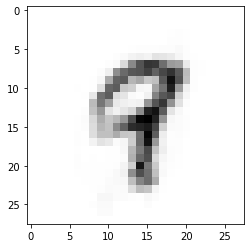

In [26]:
show_img_and_reconstruction(4)

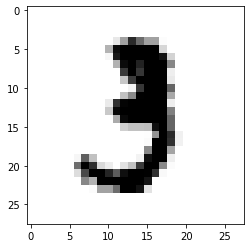

In [31]:
plt.imshow(x_train[10], cmap="Greys")

OG
Reconstruction


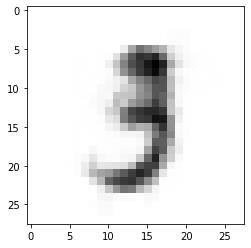

In [28]:
show_img_and_reconstruction(10)

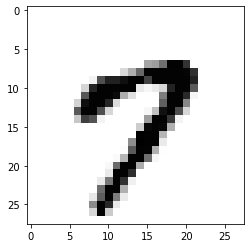

In [32]:
plt.imshow(x_train[15], cmap="Greys")

OG
Reconstruction


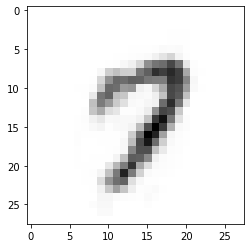

In [29]:
show_img_and_reconstruction(15)

Ok, so it's doing a reasonable job at reconstruction.  Obviously I don't have a metric to quantify this, but I'm just making that claim by eye-balling.  

On a different note, I just looked up what sparse auto-encoders are, and they are literally basically what I was going to implement next in the salusa progression.  They just enforce that a particular neuron only "fires" some small percent of the time.  The main difference between sparse auto-encoders and what I was going to do is that sparse ae's penalize neurons that are firing too much, whereas I was going to drastically increase the weights of neurons that weren't firing enough.  That's still an interesting road to go down.

## Conclusions

Surprisingly, my main conclusion is about how the output is constructed.  Previously, I'd been thinking that neurons essentially compete to create the output, and the neuron that is most activated has the "most say" in what the output would be.  At the same time, I hadn't really been thinking about reconstruction for competitive algorithms. 

The thing that I've seen here is that neurons can collaborate to reconstruct an input if instead of competing to reproduce the output (using a weighted average), they collaborate (using a sum).  This allows particular neurons to be far more specialized in what they do to reproduce an input, because they can trust that other neurons will take care of the other parts.  At the same time, learning a particular prototype does have its uses, especially if you're trying to find some recurring structure in a more broad sense.  In that case, a sparse auto-encoder, or something like that may be in order.  

As I already mentioned extensively, the other main takeaway is that this architecture is incredibly slow in its learning process.  In the future, I'll want to make simplifications to the learning algorithm so that it moves way faster.  

## Next Steps

My realization about competition versus collaboration is very interesting.  This is something that I want to explore far more.  I have a couple ideas about collaborative networks I want to implement.  First things first, I can totally simplify the learning process on the current algorithm if I simply assume each neuron's weighted average is constant when calculating the gradient.  I can also try to optimize on a pixel by pixel basis, which together with the previous assumption could yield even better results (so each pixel would have a loss function).  Actually, in just looking at the math, I think this actually happens in the approximate gradient.  Anyway, that's how I could improve this current algorithm

Another thing that might be interesting to try is to build a more traditional deep AE, but each latent neuron has its own DNN that maps to an output, and then all the outputs are added together.  This could potentially allow for more complicated correlations to occur.  Even with just two (disconnected) output levels, you could really potentially start to get interesting collaborative behavior.  The downside to this is that you would immediately have a butt ton of parameters that all need to be trained.  On the bright side, each neuron is mostly separable, so this could be highly parallelized with an FPGA.  

As a final thought, it might be a really good idea to have both collaborative and competitive behaviors in the network.  The only real difference between collaboration and competition is what's in the denominator (one's a sum of weights, the other is just 1), so you could apply something like a square root to the denominator to start to get something in between competition and collaboration.

As a second final thought, I need a different mnist metric for collaborative algorithms.  In collaboration, "winning" is far less important, and each neuron contributes to a wide variety of inputs.  I know what to do.  I simply need a classification strategy that keeps track of how activated a particular neuron is for a particular data class.  I then simply sum the individual net activations, and pick the class that is most activated after being passed through the data.  Anyway, I have a lot of different avenues to cover in the coming days.

## Data

In [6]:
import matplotlib.pyplot as plt
import pickle

good_data = pickle.load(open("data/100_n_10000_img_pae.pickle", "rb"))